# MET CS777- Final Project - Latent Dirichlet Allocation using Gibbs Sampling


### Dataset 

I worked with a dataset obtained from the Digital Corpus of the European Parliament (DCEP). The DCEP contains most of the documents published on the European Parliament's official website from press releases to session and legislative documents related to European Parliament's activities and bodies. However, for the final project, I focused on the Documents that are considered “Motions” and that are written in English. The version downloaded and pre-processed contains documents that were produced between 2001 and 2012 which totals 66,607 motions. 

The DCEP provides the documents as XML files. Below, you can see some code for data processing to be able to transform the XML file to paragraphs and how I downloaded the data to be able to access it later.

In [1]:
#importing necessary libraries
import os
import time
import re
import numpy as np
from numpy.random.mtrand import dirichlet, multinomial
import pandas as pd
import pickle
from wordcloud import WordCloud #Visualization
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np
import matplotlib.pyplot as plt
import itertools
plt.style.use("ggplot")
plt.usetex = True

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maralinetorres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maralinetorres/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Clean and prepare the data in rdd

start_time = time.time()
directory = "/Users/maralinetorres/Documents/GitHub/CS777-BigDataAnalytics/Final Project/DCEP/source/xml/EN/MOTION"

motions = {}
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def processMotionXML(XMLrdd, path):
        document = XMLrdd.filter(lambda x: "<p s:margin-bottom=" in x[:19] or "<CONTENT>" in x[:9] or "<p s:margin-left=" in x[:17]).collect()
        if len(document) == 0:
            text = XMLrdd.collect()
            p = "".join(text)
            if p.find("<CORPUS>") > 0:
                document = p[p.index("<CORPUS>")+len("CORPUS>")+1:]
            else:
                document = p[p.index("<p s:margin-left="):]
        clean_motion = remove_tags("".join(document)).replace("\xa0","")
        return clean_motion

count = 0
num_files = len([f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))])

for filename in os.scandir(directory):
    if filename.is_file() and filename.path.endswith(".xml"):
        motion = sc.textFile(filename.path)
        parr = processMotionXML(motion, filename.path)
        motions[filename.path] = parr
    count+=1
    if count == num_files:
        print("Done")

print("Total Time to run: --- %s minutes ---" % round((time.time() - start_time)/60,3))

### Saving the file to access it later 

In [ ]:
m_file = open("EuroParl-motions.pkl","wb")
pickle.dump(motions, m_file)
m_file.close()

### Loading and preparing the rdd

In [2]:
m_read_file = open("EuroParl-motions.pkl","rb")
motions_op = pickle.load(m_read_file)

In [3]:
rdd = sc.parallelize(motions_op.values()).zipWithIndex().map(lambda x: (x[1], x[0]))
#rdd.take(2)

## Visualize a few motions

In [4]:
firstM = rdd.map(lambda x: x[1]).first()
secondM = rdd.map(lambda x: x[1]).top(1)

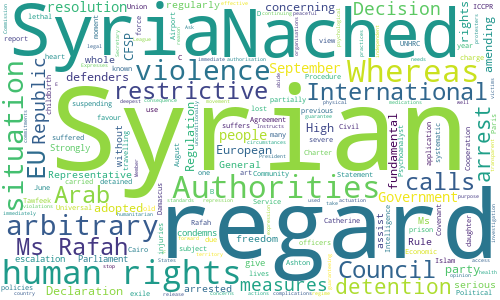

In [5]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=500, height=300)
wordcloud.generate(firstM)
wordcloud.to_image()

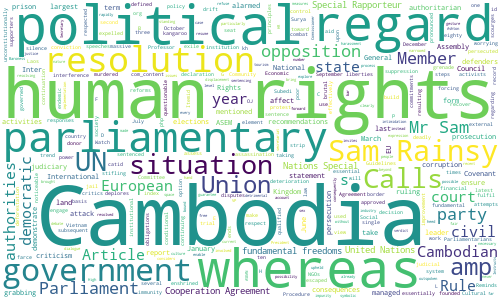

In [6]:
wordcloud.generate(secondM[0])
wordcloud.to_image()

## Data Pre-processing

### 1) Tokenization:

Converted each motion into a list of words and put them all lower case

In [7]:
regex = re.compile('[^a-zA-Z]')
d_keyAndListOfWords = rdd.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))
#d_keyAndListOfWords.first()

### 2) Perfom the following steps:

- Remove stopwords
- Remove words that have less than 3 characters 
- Lemmatized --> Changes words to singular value so it can be analyze as a single item. Brings context to the words

In [8]:
STOPWORDS = list(stopwords.words('english'))
#added some words that are repetitive in the motions
STOPWORDS.extend(['whereas','regard','member','parliament','council','calls','commission','rights','right','europe','european'])
STOPWORDS[:5]

['i', 'me', 'my', 'myself', 'we']

In [9]:
def removeStopWordsShortWordsLem(ListOfWords):
    result = []
    wnl = WordNetLemmatizer()
    for word in ListOfWords:
        if (word not in STOPWORDS and len(word) > 2):
            result.append(wnl.lemmatize(word))
    return result

In [10]:
d_keyAndListOfWords_clean = d_keyAndListOfWords.map(lambda x: (x[0], removeStopWordsShortWordsLem(x[1])))

In [ ]:
d_keyAndListOfWords_clean.first()

## Prepare the dictionary

Initially, I started with a 20K Dictionary. However, it was taking too long to run the collapsedGibbsSampling function and I was unable to run more than 100 documents because it ran out of memory. Therefore, I decided to decrease to 5K dictionary words which I create below. Each entry contains the number of times a word appears in the training set.

In [11]:
allWordsCounts = d_keyAndListOfWords_clean.flatMap(lambda x: x[1]).map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y)

In [12]:
# Getting the top 5,000 words in a local array in a sorted format based on frequency
topWords = allWordsCounts.top(5000, lambda x: x[1])
topWordsK = sc.parallelize(range(5000))
dictionary = topWordsK.map(lambda x:(topWords[x][0], x))

In [13]:
print("Word Postions in our Feature Matrix. Last 20 words (less frequent) in 5k positions: ", dictionary.top(20, lambda x : x[1]))

Word Postions in our Feature Matrix. Last 20 words (less frequent) in 5k positions:  [('venture', 4999), ('policing', 4998), ('participatory', 4997), ('reopening', 4996), ('judged', 4995), ('counsel', 4994), ('translate', 4993), ('deprivation', 4992), ('intensifying', 4991), ('contrast', 4990), ('observing', 4989), ('mobilised', 4988), ('season', 4987), ('realise', 4986), ('retaliation', 4985), ('shield', 4984), ('naval', 4983), ('goldstone', 4982), ('csdp', 4981), ('enacted', 4980)]


In [14]:
print("Word Postions in our Feature Matrix. first 20 words (more frequent) in 5k positions: ", dictionary.top(20, lambda x : -x[1]))

Word Postions in our Feature Matrix. first 20 words (more frequent) in 5k positions:  [('state', 0), ('human', 1), ('country', 2), ('government', 3), ('international', 4), ('resolution', 5), ('union', 6), ('rule', 7), ('policy', 8), ('development', 9), ('president', 10), ('political', 11), ('agreement', 12), ('authority', 13), ('security', 14), ('support', 15), ('economic', 16), ('law', 17), ('new', 18), ('people', 19)]


### Creating the Bag of Words

In [15]:
def buildBOWTuple(docId, listOfIndexes):
    values = pd.Series(listOfIndexes).value_counts().values
    numWords = np.sum(values)
    return (docId, listOfIndexes,numWords)

In [16]:
# Next, we get a RDD that has, for each (docID, ["word1", "word2", "word3", ...]),
# ("word1", docID), ("word2", docId), ...
allWordsWithDocID = d_keyAndListOfWords_clean.flatMap(lambda x: ((j, x[0]) for j in x[1]))

# Now join and link them, to get a set of ("word1", (dictionaryPos, docID)) pairs
dictionary_small_dataset = dictionary.collectAsMap()
sc.broadcast(dictionary_small_dataset)
#Let's do a simple map on it
allDictionaryWords=allWordsWithDocID.map(lambda x: (x[0], (dictionary_small_dataset.get(x[0]), x[1])) if x[0] in dictionary_small_dataset.keys() else None).filter(lambda x: x!=None)

# Now, we drop the actual word itself to get a set of (docID, dictionaryPos) pairs
justDocAndPos = allDictionaryWords.map(lambda x: (x[1][1],x[1][0]))
# Now get a set of (docID, [dictionaryPos1, dictionaryPos2, dictionaryPos3...]) pairs
allDictionaryWordsInEachDoc = justDocAndPos.groupByKey()
result = allDictionaryWordsInEachDoc.mapValues(list).map(lambda x: buildBOWTuple(x[0], x[1]))
# (Document Id, [List of indexes], number of words in that document)
#result.take(3)

Remove the other document id and created new ones to start from 0 to result.count()

In [17]:
motions = result.map(lambda x: (x[1],x[2])).zipWithIndex().map(lambda x: (x[1], x[0][0], x[0][1]))
motions.first()

(0,
 [1760,
  12,
  967,
  3245,
  1772,
  62,
  337,
  158,
  87,
  432,
  1457,
  2013,
  222,
  158,
  125,
  1484,
  158,
  432,
  1457,
  2013,
  222,
  158,
  3132,
  125,
  62,
  158,
  2439,
  38,
  492,
  33,
  240,
  1015,
  492,
  463,
  626,
  48,
  198,
  1240,
  182,
  207,
  205,
  131,
  0,
  112,
  23,
  273,
  288,
  159,
  5,
  92,
  170,
  205,
  2794,
  22,
  3521,
  244,
  23,
  249,
  171,
  1493,
  453,
  5,
  200,
  523,
  628,
  1457,
  2013,
  222,
  5,
  125,
  1015,
  3194,
  159,
  18,
  2762,
  62,
  82,
  3854,
  1233,
  145,
  1224,
  4539,
  171,
  143,
  314,
  124,
  7,
  7,
  40,
  281,
  208,
  15,
  30,
  311,
  2086,
  812,
  2607,
  735,
  1457,
  62,
  16,
  123,
  6,
  461,
  455,
  353,
  60,
  2936,
  2518,
  774,
  156,
  4988,
  2607,
  735,
  62,
  16,
  123,
  2540,
  1386,
  142,
  1281,
  4155,
  1179,
  411,
  15,
  311,
  96,
  195,
  161,
  62,
  16,
  123,
  1107,
  955,
  875,
  1215,
  420,
  812,
  2607,
  69,
  1035,
  266,
  1

## Let's start working with the LDA


I worked with the following logic to execute to complete to be able to run the following process:

<img src="LDA Gibbs Sampling.png" width=400 height=400 />

Initially, I tried to run the process with the complete dataset but I ran out of memory. Therefore, I ran it only for the first 3,000 documents


1) Initialiaze important parameters, numpy arrays and necessary functions

In [26]:
result = motions.filter(lambda x: x[0] in np.arange(3000).tolist()).map(lambda x: (x[1],x[2])).zipWithIndex().map(lambda x: (x[1], x[0][0], x[0][1]))
result.cache()

topics = 10

alpha = 0.1 # the parameter for document topic distributions
beta = 0.1 # the parameter for topic word distribution


NumDocs = result.count() #Number of documents
vocab = dictionary.map(lambda x: x[0]).collect()

cTW = np.zeros((topics, len(vocab)))  #the number of times the word is assigned to the topic
cDT = np.zeros((NumDocs, topics)) #the count of of topic j assigned to some word token in document d

n_d = np.zeros((NumDocs)) #the number of words of each document, we already have that in the rdd
n_z = np.zeros((topics)) #the number of times any word is assigned to topic k


print(f'Number of documents: {NumDocs}')
print(f'Number of topics (categories) I want to identify: {topics}')

Number of documents: 3000
Number of topics (categories) I want to identify: 10


In [19]:
 def generateTopic(NumWords):
    n_w_t = [0 for _ in range(NumWords)]    
    for n in range(NumWords):
        n_w_t[n] = np.random.randint(0, topics)
    return n_w_t   

def getTopicAssignedToWord(docId,numWords):
    topicsAssigned = []
    for n in range(numWords):
        z = z_i_j[docId][n]
        topicsAssigned.append(z)
    return topicsAssigned

def buildcDT(topicsVals):
    n_d_t = np.zeros(topics)
    x, counts = np.unique(topicsVals, return_counts=True)
    n_d_t[x] = counts
    return n_d_t

def buildcTopicWord(words, topics):
    wt = []
    for n, word in enumerate(words):
        wt.append((word, topics[n]))
    return wt

2) Assign random topic to each word of each document

In [27]:
#randomly assign topic to each word of each document
z_i_j = result.map(lambda x: generateTopic(x[2])).collect()
z_i_j[0][5] #Topic assignment for word 5 in the document 0

5

3) Get the topic assignment for each word and generate the CDT

In [28]:
#(Document Id, {VocabIndex: Word occurence in document}, Number of words in document, Topic assigned to each word)
rdd = result.map(lambda x: (x[0],x[1], x[2], getTopicAssignedToWord(x[0], x[2])))
rdd1 = rdd.map(lambda x: (x[0], x[1], x[2],x[3],buildcDT(x[3])))
cDT = np.stack(rdd1.map(lambda x: x[4]).collect())
#print(cDT)

In [ ]:
np.sum(cDT)

4) Generate the cTW

In [29]:
#Pass List of words, topics
ctw = rdd1.map(lambda x: buildcTopicWord(x[1], x[3])).flatMap(lambda x: x).map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).collect()
for tw in ctw:
    cTW[tw[0][1], tw[0][0]] = tw[1]
    
cTW

array([[1.347e+03, 9.910e+02, 1.005e+03, ..., 4.000e+00, 2.000e+00,
        4.000e+00],
       [1.341e+03, 1.023e+03, 9.930e+02, ..., 3.000e+00, 0.000e+00,
        3.000e+00],
       [1.302e+03, 1.046e+03, 9.760e+02, ..., 3.000e+00, 0.000e+00,
        3.000e+00],
       ...,
       [1.346e+03, 1.058e+03, 1.000e+03, ..., 1.000e+00, 1.000e+00,
        2.000e+00],
       [1.383e+03, 1.039e+03, 9.840e+02, ..., 2.000e+00, 0.000e+00,
        1.000e+00],
       [1.330e+03, 9.600e+02, 9.700e+02, ..., 2.000e+00, 2.000e+00,
        4.000e+00]])

5) Get the n_z variable

In [30]:
n_z = np.sum(cTW, axis=1) #the number of times any word is assigned to topic k
n_z

array([137044., 135811., 134475., 135402., 134149., 136079., 136562.,
       137274., 136214., 135798.])

6) Created a function to go through each word and calculate the new topic. The function parameters are the document id, list of words, number of words in the document (nd), the topics assigned to each word in the document, the number of times the word is assigned to the topic (phi),the count of of topic j assigned to some word token in document and the number of times any word is assigned to topic k (nk). 

This is the formula used to calculate the new topic for the word:


<img src="Probability Formula.png" width=400 height=400 />

In [24]:
def collapsedGibbsSampling(docId, doc, numWords, z_w_t, phi_wt, theta_d_t, n_z_topic):
    vocabulary = len(phi_wt[0])
    numTopics = len(phi_wt)
    alpha = 1 / numTopics
    beta = 1 / numTopics
    
    for n, word in enumerate(doc):
        #get topic
        z = z_w_t[n]
        
        # decrement counts for word w with associated topic z because now we are 
        #going to assign it a new topic
        theta_d_t[z]-= 1
        phi_wt[z, word]-=1
        n_z_topic[z]-=1

        #Calculate the new topic for the word using the formula presented above. 
        prob_dt = (theta_d_t + alpha) / (numWords - 1 + numTopics * alpha)
        prob_topic_w = (phi_wt[:, word] + beta) / (n_z_topic + vocabulary * beta)
        p_z = prob_dt * prob_topic_w
        p_z /= np.sum(p_z)
        new_z = np.random.multinomial(1, p_z).argmax()

        # Update the topic assignment for the word 
        #And increment count for the new topic assigned
        z_w_t[n] = new_z
        theta_d_t[new_z] += 1
        phi_wt[new_z, word] += 1
        n_z_topic[new_z] += 1

    return (docId, doc, numWords, z_w_t, theta_d_t, phi_wt, n_z_topic)

In [31]:
start_time = time.time()
for iteration in (range(50)):
    print(f'Iteration {iteration}')   
    
    resultGibbs = rdd1.map(lambda x: collapsedGibbsSampling(x[0], x[1], x[2], x[3], cTW, x[4], n_z)).cache()
    
    rdd1 = resultGibbs.map(lambda x: (x[0],x[1], x[2], x[3], x[4])).cache()

    cTW = np.zeros((topics, len(vocab))) 
    #Pass List of words and topics assigned
    ctw = rdd1.map(lambda x: buildcTopicWord(x[1], x[3])).flatMap(lambda x: x).map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).collect()
    #Update the phi to get the new topic assigned to each word
    for tw in ctw:
        cTW[tw[0][1], tw[0][0]] = tw[1]
     
    #Update the nz (nd) to get the new number of times any word is assigned to topic k
    n_z = np.sum(cTW, axis=1) 

print("Total Time to run: --- %s minutes ---" % round((time.time() - start_time)/60,3))

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Total Time to run: --- 11.8 minutes ---


In [32]:
finalcDT = np.stack(rdd1.map(lambda x: x[4]).collect())
finalcDT

array([[  0.,  46.,   0., ...,   1.,   1.,   0.],
       [  0.,   0.,   0., ...,  25.,   7.,   0.],
       [  0., 129.,   0., ...,   2.,  19.,   0.],
       ...,
       [  0., 102.,   0., ..., 134., 182.,   0.],
       [  0.,   0.,  24., ...,  61.,  53.,   0.],
       [  1., 374.,  20., ...,   0.,   0.,  44.]])

### Extract the topics

In [33]:
inv_vocabulary = {v: k for k, v in dictionary_small_dataset.items()}
number_top_words = 10
topicWords = {}
for num, topic in enumerate(cTW):
    top20Words = sc.parallelize(topic).zipWithIndex().top(number_top_words, lambda x: x[0])
    wordsInTopic = []
    for quantIndex in top20Words:
        word = quantIndex[1]
        wordsInTopic.append(inv_vocabulary[word])
        topicWords[num] = wordsInTopic
    print(f'Topic #{num} : {" ".join(wordsInTopic)}')

Topic #0 : human government international resolution authority state death freedom president law
Topic #1 : state agreement country cooperation welcome union security negotiation process new
Topic #2 : article state burma rule human law union data president protection
Topic #3 : woman child country state discrimination rom health people human sexual
Topic #4 : election government political authority human belarus democratic freedom rule president
Topic #5 : policy energy development strategy social economic sustainable need climate stress
Topic #6 : state country aid community region disaster area rule measure affected
Topic #7 : government international security peace resolution humanitarian state palestinian force president
Topic #8 : russia country russian food development trade world wto developing international
Topic #9 : state proposal market social directive financial public policy measure rule


### Topic 0

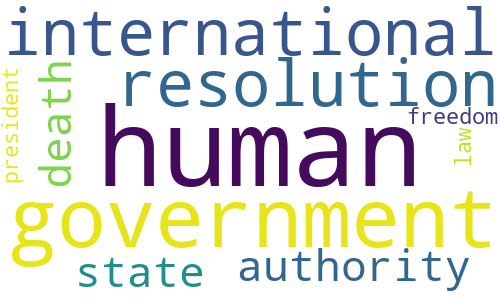

In [34]:
wordcloud.generate(" ".join(topicWords[0]))
wordcloud.to_image()

### Topic 1

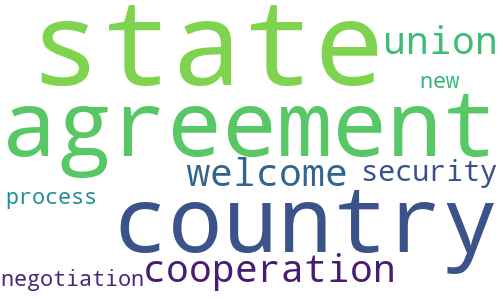

In [35]:
wordcloud.generate(" ".join(topicWords[1]))
wordcloud.to_image()

### Topic 2

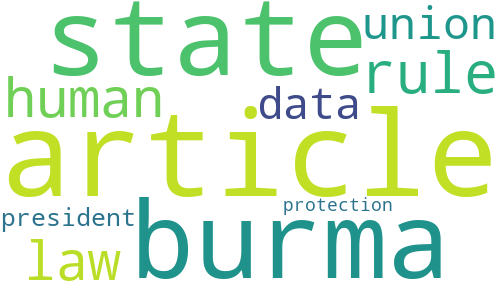

In [36]:
wordcloud.generate(" ".join(topicWords[2]))
wordcloud.to_image()

### Topic 3

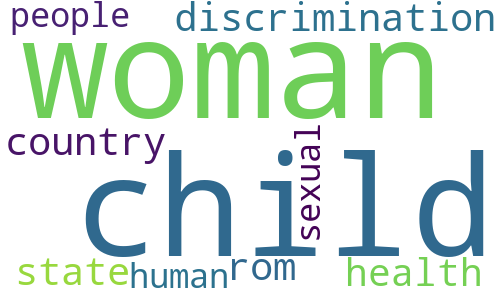

In [37]:
wordcloud.generate(" ".join(topicWords[3]))
wordcloud.to_image()

### Topic 4

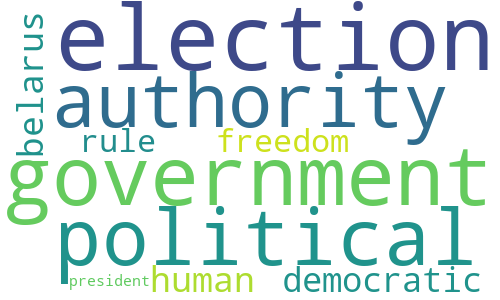

In [38]:
wordcloud.generate(" ".join(topicWords[4]))
wordcloud.to_image()

### Topic 5

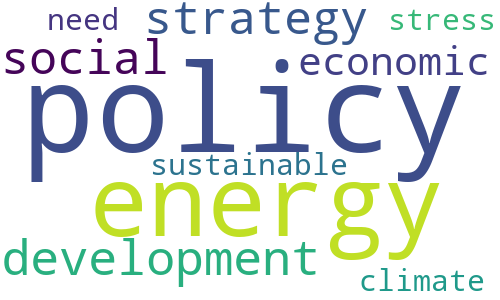

In [39]:
wordcloud.generate(" ".join(topicWords[5]))
wordcloud.to_image()

### Topic 6

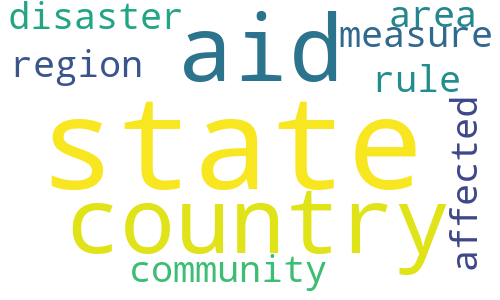

In [40]:
wordcloud.generate(" ".join(topicWords[6]))
wordcloud.to_image()

### Topic 7

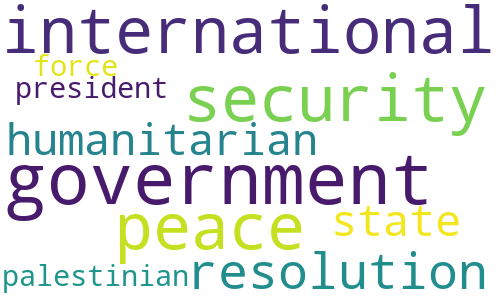

In [41]:
wordcloud.generate(" ".join(topicWords[7]))
wordcloud.to_image()

### Topic 8

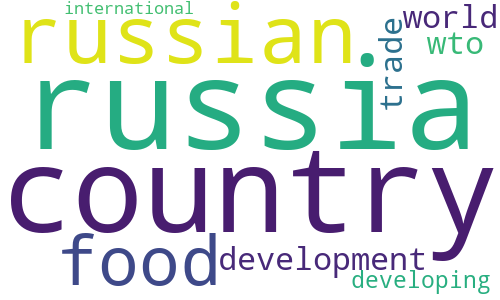

In [42]:
wordcloud.generate(" ".join(topicWords[8]))
wordcloud.to_image()

### Topic 9

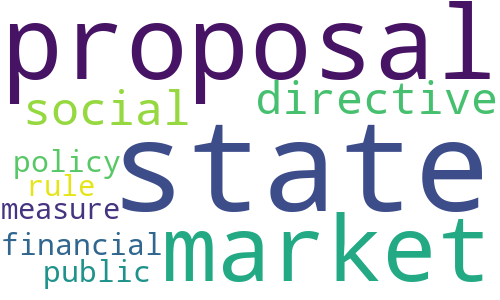

In [43]:
wordcloud.generate(" ".join(topicWords[9]))
wordcloud.to_image()

### Evaluate the topic model

I evaluated the topic coherence using intrinsic UMass measure

The Umass measure uses the following pairwise score function:

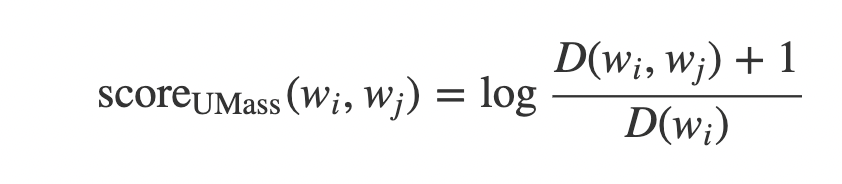

- Dwi = The count of documents containing the word i


- Dwi,wj = the count of documents containg the word i and j

I created the following functions to be able to calculate it

In [46]:
def getDictionaryIndex(listOfWords):
    listIndexes = []
    for word in listOfWords:
        listIndexes.append(dictionary_small_dataset[word])
    return listIndexes

def correctDocuments(p, w0, w1=0):
    if w1 == 0:
        for w in p[1]:
            if w == w0:
                return p
    else:
        exists = all(x in p[1] for x in [w0,w1])
        if exists:
            return p
        
def getDwi(topic10Words):
    topicIndexes = getDictionaryIndex(topic10Words)
    document_wordCount = {}
    for index in topicIndexes:
        count = result.filter(lambda x: correctDocuments(x, index)).count()
        document_wordCount[index] = count
    return document_wordCount

def getDwiWj(topic10Words, word):
    allCombinations = list(itertools.combinations(topic10Words,2))
    combinationCount = {}
    for cmb in allCombinations:
        if word == cmb[0]:
            wordsComb = getDictionaryIndex(list(cmb))
            count = result.filter(lambda x: correctDocuments(x, wordsComb[0], wordsComb[1])).count()
            dictIndex = str(wordsComb[0]) + "," + str(wordsComb[1])
            combinationCount[dictIndex] = count
    return combinationCount

def calculateTopicCoherence(listOfWords):
    allDwi = getDwi(listOfWords)
    score = {}
    for key, val in allDwi.items():
        dwiWj = getDwiWj(listOfWords, inv_vocabulary[key]) #get the dwiWj
        for pairs, count in dwiWj.items():
            cal = np.log((count + 1)/val) #do the calculation from the above formula
            score[pairs] = cal
    return np.sum(list(score.values()))

In [47]:
topicScore = {}
for num, words in topicWords.items():
    #print(num, words)
    coherence = calculateTopicCoherence(words)
    indexing = f'Topic #{num}'
    topicScore[indexing] = coherence
topicScore

{'Topic #0': -21.925290929802497,
 'Topic #1': -25.9139719398116,
 'Topic #2': -40.32076465628136,
 'Topic #3': -50.316693768256144,
 'Topic #4': -26.18779733624818,
 'Topic #5': -31.165514353272588,
 'Topic #6': -43.99838004335242,
 'Topic #7': -31.05125546865605,
 'Topic #8': -42.219543260520126,
 'Topic #9': -26.419070323690654}

For u_mass score, the lowest negative point is the best (the more coherent). As presented, the majority of the topics have high score which represents they are less coherent. Therefore, the words are not all well-connected not in context or heading to the same direction. 

By evaluating the model, I could tweak the hyperparameters (alpha and beta, even number of topics) to get better results. However, for this project purposes and because of time limitations, I left it like that and continue to implement LDA with MLLib

## Now, let's run the LDA using Machine Learning and Spark Libraries

MLLib LDA use Expectation-Maximization (E-M) for clustering and yield comprenhensive results. Before, I did the Latent Dirichlet Allocation based on collapsed Gibbs Sampling. 

For this part, I am going to use 4,500 documents, and mantain the 5K vocabulary and 10 topics. 

In [48]:
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel

First, I created a function to convert the document dictionary word indexes into a vector 'bag of words' where the vocabulary size is the length of the vector. In this case, 5k.

In [49]:
#1) Tokenization
def buildCountWordsArray(listOfIndexes):
    counts = pd.Series(listOfIndexes).value_counts()
    x5K = pd.Series(np.zeros(5000).tolist())
    y = pd.concat([x5K, counts], axis=1, join='outer')
    y.columns = ['Mock','Real']
    y.drop(columns=['Mock'], inplace=True)
    y.fillna(0, inplace=True)
    return y.Real.values

resultLDA = allDictionaryWordsInEachDoc.mapValues(list).map(lambda x: [int(x[0]), Vectors.dense(buildCountWordsArray(x[1]))])                                                                                        

In [50]:
data_lda = resultLDA.filter(lambda x: x[0] in np.arange(4500).tolist())  

The LDA train accepts an rdd with unique Id and a vector of counts. It accepts the number of topics, number of iterations , docConectration (alpha) and topicConcentration (beta) as parameters. 

For this project purposes, I left the alpha and beta with the default values and ran 100 iterations to identify 10 topics.

In [51]:
start_time = time.time()
lda_model = LDA.train(data_lda, k=10, maxIterations=100)
print("Total Time to run: --- %s minutes ---" % round((time.time() - start_time)/60,3))

Total Time to run: --- 15.464 minutes ---


In [52]:
lda_topics = lda_model.topicsMatrix()
number_top_words = 10
lda_topicWords = {}
for num in range(10):
    top20Words = sc.parallelize(lda_topics[:,num]).zipWithIndex().top(number_top_words, lambda x: x[0])
    wordsInTopic = []
    for quantIndex in top20Words:
        word = quantIndex[1]
        wordsInTopic.append(inv_vocabulary[word])
        lda_topicWords[num] = wordsInTopic
    print(f'Topic #{num} : {" ".join(wordsInTopic)}')

Topic #0 : international state peace security humanitarian government resolution conflict palestinian force
Topic #1 : country welcome union cooperation process agreement development policy political support
Topic #2 : election democratic president state political rule authority belarus medium parliamentary
Topic #3 : human government political death president people international situation general resolution
Topic #4 : state agreement trade rule article nuclear treaty regulation wto negotiation
Topic #5 : human state woman government law freedom fundamental union child discrimination
Topic #6 : russia human russian iran authority government republic china cooperation resolution
Topic #7 : country development aid world food health developing people million international
Topic #8 : state energy area climate change region measure community oil disaster
Topic #9 : social policy economic market strategy state financial proposal new development


### Evaluate the model

Used similar functions from before and calculated the topic coherence for the LDA model using MLLib

In [146]:
def correctDocumentsLDA(p, w0, w1=0):
    exists = False
    if w1 == 0:
        for w in p:
            if w == w0:
                exists = True
    else:
        exists = all(x in p for x in [w0,w1])
    return exists

def convertToIndexes(p):
    words = []
    #get words that really exist in the document
    for n, v in enumerate(p[1]):
        if v != 0:
            words.append(n)
    return (p[0], words)
        
def getDwiLDA(topic10Words):
    topicIndexes = getDictionaryIndex(topic10Words)
    document_wordCount = {}
    count = 0
    for index in topicIndexes:
        #count = rdd_converted.filter(lambda x: correctDocuments(x, index)).count()
        for key, value in dict_LDA.items():
            count += correctDocumentsLDA(value, index)
        document_wordCount[index] = count
    return document_wordCount

def getDwiWjLDA(topic10Words, word):
    allCombinations = list(itertools.combinations(topic10Words,2))
    combinationCount = {}
    count = 0
    for cmb in allCombinations:
        if word == cmb[0]:
            wordsComb = getDictionaryIndex(list(cmb))
            #count = rdd_converted.filter(lambda x: correctDocuments(x, wordsComb[0], wordsComb[1])).count()
            for key, value in dict_LDA.items():
                count += correctDocumentsLDA(value, wordsComb[0], wordsComb[1])
            dictIndex = str(wordsComb[0]) + "," + str(wordsComb[1])
            combinationCount[dictIndex] = count
    return combinationCount

def calculateTopicCoherenceLDA(listOfWords):
    allDwi = getDwiLDA(listOfWords)
    score = {}
    for key, val in allDwi.items():
        dwiWj = getDwiWjLDA(listOfWords, inv_vocabulary[key]) #get the dwiWj
        for pairs, count in dwiWj.items():
            cal = np.log((count + 1)/val) #do the calculation from the above formula
            score[pairs] = cal
    return np.sum(list(score.values()))

In [147]:
start_time = time.time()
rdd_converted = data_lda.map(convertToIndexes)
dict_LDA = rdd_converted.collectAsMap()
topicScoreLDA = {}
for num, words in lda_topicWords.items():
    #print(num, words)
    coherence = calculateTopicCoherenceLDA(words)
    indexing = f'Topic #{num}'
    topicScoreLDA[indexing] = coherence
    
print("Total Time to run: --- %s minutes ---" % round((time.time() - start_time)/60,3))
topicScoreLDA

Total Time to run: --- 0.235 minutes ---


{'Topic #0': -37.954871047525,
 'Topic #1': -24.425770500919374,
 'Topic #2': -21.370700844447516,
 'Topic #3': -23.159670120694297,
 'Topic #4': -65.0531982167055,
 'Topic #5': -38.85280131753303,
 'Topic #6': -40.99278985286866,
 'Topic #7': -54.35913927437574,
 'Topic #8': -61.31522172978495,
 'Topic #9': -27.18121794409782}

## Reference Links


### LDA Machine Learning Libraries

   - https://spark.apache.org/docs/latest/mllib-clustering.html
    https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.clustering.LDA.html#pyspark.mllib.clustering.LDA
    

### Topic Coherence

- http://qpleple.com/topic-coherence-to-evaluate-topic-models/